## Implementation of RFUAV-net
July 1, 2022 \
efficient CNN method \
status: testing with a small sample

In [303]:
import os
import numpy as np
from sklearn.model_selection import KFold
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [304]:
## helper functions
def normalize_rf(rf):
    """apply normalization to data in the numpy array format"""
    rfnorm = []
    for i in range(len(rf)):
        rfnorm_i = np.zeros(rf[i].shape)
        for j in range(2):
#             print(rf[i][j])
            r = (np.max(rf[i][j])-np.min(rf[i][j]))
#             print('range:', r)
            m = np.min(rf[i][j])
#             print('m:', m)abs
            rfnorm_i[j] = (rf[i][j]-m)/r
#             print(rfnorm_i[j])
        rfnorm.append(rfnorm_i)

    return rfnorm

In [83]:
## Import data -  Drone RF
main_folder = '/home/kzhou/Data/DroneRF/'
high_freq_files = os.listdir(main_folder+'High/')
low_freq_files = os.listdir(main_folder+'Low/')

high_freq_files.sort()
low_freq_files.sort()
fs = 40e6 #40 MHz

# feature & results lists
Xs = []
ys = []
y4s = []
y10s = []

for i in range(100):

    # load RF data
    rf_data_h = pd.read_csv(main_folder+'High/'+high_freq_files[i], header=None).values
    rf_data_h = rf_data_h.flatten()
    
    rf_data_l = pd.read_csv(main_folder+'Low/'+low_freq_files[i], header=None).values
    rf_data_l = rf_data_l.flatten()
    
    if len(rf_data_h)!=len(rf_data_l):
        print('diff', i, 'file name:', low_freq_files[i]) 
        # not sure why one pair of files have different lengths (ignore this for now)
    else:
        # stack the features and ys
        rf_sig = np.vstack((rf_data_h, rf_data_l))
        rf_sig = np.split(rf_sig, 1000, axis =1) # samples of 1e4
        Xs.append(normalize_rf(rf_sig))
        
        y_rep = np.repeat(int(low_freq_files[i][0]),1000)
        y4_rep = np.repeat(int(low_freq_files[i][:3]),1000)
        y10_rep = np.repeat(int(low_freq_files[i][:5]),1000)

        ys.append(y_rep) # 2 class
        y4s.append(y4_rep) # 4 class
        y10s.append(y10_rep) # 10 class

        if int(high_freq_files[i][:5])!= int(low_freq_files[i][:5]):
            raise Exception("File labels do not match")

diff 5 file name: 00000L_13.csv


In [84]:
# shape the arrays
Xs_arr = np.array(Xs)
Xs_arr = Xs_arr.reshape(-1, *Xs_arr.shape[-2:])
ys_arr = np.array(ys).flatten()
y4s_arr = np.array(y4s).flatten()
y10s_arr = np.array(y10s).flatten()

In [85]:
Xs_arr.shape

(99000, 2, 10000)

### Apply Model

In [18]:
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch
import torchvision.models as models

In [343]:
## Define dataset
## Create a dataset class
## Creating a custom dataset
class DroneRFData(Dataset): ## NUMBERICAL DATA
    def __init__(self, Xarr, yarr):
        self.Xarr = Xarr.astype(np.float32)
        self.le = preprocessing.LabelEncoder()
        self.le.fit(yarr.flatten())
        self.yarr = self.le.transform(yarr.flatten())
        
    def __len__(self):
        return len(self.yarr)
    
    def __getitem__(self, index):
        # all data must be in float and tensor format
        X = torch.tensor((self.Xarr[index]))
#         print(X.shape)
        X = X.unsqueeze(0)
        y = torch.tensor(float(self.yarr[index]))
        return (X, y)

In [344]:
dataset = DroneRFData(Xs_arr, ys_arr)

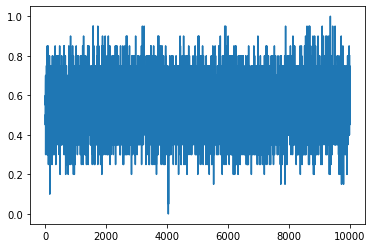

In [345]:
plt.plot(dataset.__getitem__(40)[0][0][1].numpy())

In [411]:
class RFUAVNet(nn.Module):
    #  Determine what layers and their order in CNN object 
    def __init__(self, num_classes):
        super(RFUAVNet, self).__init__()
        self.num_classes = num_classes

        self.dense = nn.Linear(320, num_classes)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.smax = nn.Softmax(dim=0)
        
        # for r unit
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=64, kernel_size=5, stride=5)
        self.norm1 = nn.BatchNorm1d(num_features=64)
        self.elu1 = nn.ELU(alpha=1.0, inplace=False)
        
        # setup for components of the gunit
        self.groupconvlist = []
        self.norm2list = []
        self.elu2list = []
        for i in range(4):
            self.groupconvlist.append( nn.Conv1d( 
                  in_channels=64,
                  out_channels=64,
                  kernel_size=2,
                    stride = 2,
                  groups=8,
    #               bias=False,
                  dtype=torch.float32
                ))
            self.norm2list.append(nn.BatchNorm1d(num_features=64))
            self.elu2list.append(nn.ELU(alpha=1.0, inplace=False))
        self.groupconv = nn.ModuleList(self.groupconvlist)
        self.norm2 = nn.ModuleList(self.norm2list)
        self.elu2 = nn.ModuleList(self.elu2list)
        
        # multi-gap implementation
        self.avgpool1000 = nn.AvgPool1d(kernel_size=1000)
        self.avgpool500 = nn.AvgPool1d(kernel_size=500)
        self.avgpool250 = nn.AvgPool1d(kernel_size=250)
        self.avgpool125 = nn.AvgPool1d(kernel_size=125)
    
    # Progresses data across layers    
    def forward(self, x):
        # runit first
        x1 = self.runit(x)
# #         print('x1 shape', x1.shape)
        xg1 = self.gunit(x1, 0) # output of this layer should be 1000, but why 999?
        x2 = self.pool(x1)
        x3 = xg1+x2
        
#         print('x3 shape', x3.shape)
        xg2 = self.gunit(x3, 1)
        x4 = self.pool(x3)
        x5 = xg2+x4
        
#         print('x5 shape', x5.shape)
        xg3 = self.gunit(x5, 2)
        x6 = self.pool(x5)
        x7 = x6+xg3
        
        xg4 = self.gunit(x7, 3)
        x8 = self.pool(x7)
        x_togap = x8+xg4
        
#         print('xg1 shape:', xg1.shape)
        
#         # CONTINUE from the gap and multi-gap implementation
        f_gap_1 = self.avgpool1000(xg1)
#         print('gap 1 shape', f_gap_1.shape)
        f_gap_2 = self.avgpool500(xg2)
#         print('gap 2 shape', f_gap_2.shape)
        f_gap_3 = self.avgpool250(xg3)
#         print('gap 3 shape', f_gap_3.shape)
        f_gap_4 = self.avgpool125(xg4)
#         print('gap 4 shape', f_gap_4.shape)
        
        f_multigap = torch.cat((f_gap_1,f_gap_2, f_gap_3, f_gap_4), 1)
#         print('f_multigap shape:',f_multigap.shape)
        
#         print('shape of x to gap', x_togap.shape)
        f_gap_add = self.avgpool125(x_togap)
    
        f_final = torch.cat((f_multigap, f_gap_add),1)
#         print('avg pool:', self.avgpool1(xg3).shape)
        f_flat = f_final.flatten(start_dim=1)
    
        f_fc = self.dense(f_flat)
        out = self.smax(f_fc)
        # fc_layer
        
        return out
    
    def runit(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.elu1(x)
        return x
        
    def gunit(self, x, n):
        # group convolution layer 8 by 8
        # norm
        # elu
        # n indicates which gunit
        x = self.groupconv[n](x) 
        x = self.norm2[n](x)
        x = self.elu2[n](x)
        return x

In [413]:
## Test network
# input1 = dataset.__getitem__(40)[0]
# input1= input1.type(torch.float)
# input = input.reshape(1, 2, 10000)
input1 = torch.rand(128, 2, 10000)

print(input1.shape)

# input_1d = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype = torch.float)

net = RFUAVNet(2)
out = net(input1)

print(out.shape)

torch.Size([128, 2, 10000])
torch.Size([128, 2])


In [425]:
# Set up data and parameters
## Set up Data
train_split_percentage = 0.9
split_lengths = [int(train_split_percentage*len(dataset)), len(dataset)-int(train_split_percentage*len(dataset))]
train_set, test_set = torch.utils.data.random_split(dataset, split_lengths)

train_loader = torch.utils.data.DataLoader(dataset = train_set,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_set,
                                           batch_size = batch_size,
                                           shuffle = True)


## Set up Model
# Hyperparameters
batch_size = 128 # the number of samples processed before the model is updated. (number of samples in the training data)
num_classes = 2
learning_rate = 0.01
num_epochs = 90
momentum = 0.95

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = RFUAVNet(num_classes)
model = model.to(device)

# Set Loss function with criterion
criterion = nn.CrossEntropyLoss()

# Set optimizer with optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4, momentum = momentum)  

total_step = len(train_loader)

In [426]:
# Training
# We use the pre-defined number of epochs to determine how many iterations to train the network on
for epoch in range(num_epochs):
    #Load in the data in batches using the train_loader object
    for i, (images, labels) in enumerate(train_loader): 
        
        labels = labels.type(torch.long)

        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        images = torch.squeeze(images, 1)
#         images= images.type(torch.cuda.FloatTensor)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if epoch%10 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))


Epoch [1/90], Loss: 0.6991
Epoch [11/90], Loss: 0.6264
Epoch [21/90], Loss: 0.6203
Epoch [31/90], Loss: 0.6169
Epoch [41/90], Loss: 0.6214
Epoch [51/90], Loss: 0.6218
Epoch [61/90], Loss: 0.6184
Epoch [71/90], Loss: 0.6158
Epoch [81/90], Loss: 0.6198


In [427]:
## Check accuracy
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        images = torch.squeeze(images, 1)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
#         print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the {} train images: {} %'.format(total, 100 * correct / total))


Accuracy of the network on the 9900 train images: 97.96969696969697 %


In [431]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [432]:
get_n_params(model)

6338

In [ ]:
# Kfold cross validation
# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)

# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

# Print
print(f'FOLD {fold}')
print('--------------------------------')

# Sample elements randomly from a given list of ids, no replacement.
train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

# Define data loaders for training and testing data in this fold
trainloader = torch.utils.data.DataLoader(
                  dataset, 
                  batch_size=10, sampler=train_subsampler)
testloader = torch.utils.data.DataLoader(
                  dataset,
                  batch_size=10, sampler=test_subsampler)

# Init the neural network
network = SimpleConvNet()
network.apply(reset_weights)

# Initialize optimizer
optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)

# Run the training loop for defined number of epochs
for epoch in range(0, num_epochs):

  # Print epoch
  print(f'Starting epoch {epoch+1}')

  # Set current loss value
  current_loss = 0.0

  # Iterate over the DataLoader for training data
  for i, data in enumerate(trainloader, 0):

    # Get inputs
    inputs, targets = data

    # Zero the gradients
    optimizer.zero_grad()

    # Perform forward pass
    outputs = network(inputs)

    # Compute loss
    loss = loss_function(outputs, targets)

    # Perform backward pass
    loss.backward()

    # Perform optimization
    optimizer.step()

    # Print statistics
    current_loss += loss.item()
    if i % 500 == 499:
        print('Loss after mini-batch %5d: %.3f' %
              (i + 1, current_loss / 500))
        current_loss = 0.0

# Process is complete.
print('Training process has finished. Saving trained model.')

# Print about testing
print('Starting testing')

# Saving the model
save_path = f'./model-fold-{fold}.pth'
torch.save(network.state_dict(), save_path)

# Evaluationfor this fold
correct, total = 0, 0
with torch.no_grad():

  # Iterate over the test data and generate predictions
  for i, data in enumerate(testloader, 0):

    # Get inputs
    inputs, targets = data

    # Generate outputs
    outputs = network(inputs)

    # Set total and correct
    _, predicted = torch.max(outputs.data, 1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

  # Print accuracy
  print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
  print('--------------------------------')
  results[fold] = 100.0 * (correct / total)

# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
sum = 0.0
for key, value in results.items():
print(f'Fold {key}: {value} %')
sum += value
print(f'Average: {sum/len(results.items())} %')